# Planar data classification with one hidden layer

Welcome to your day4 programming section. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/ 

## 1 - import python files ##

Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt

import sklearn
# Dataset
import sklearn.datasets
# Model
import sklearn.linear_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback,ModelCheckpoint

# Split train and test sets
from sklearn.model_selection import train_test_split

# This is how we usually import written py files to use the functions/classes in those files
from testCases import *
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

# Visualization
%matplotlib inline
from mlxtend.plotting import plot_decision_regions

np.random.seed(1) # set a seed so that the results are consistent

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [2]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

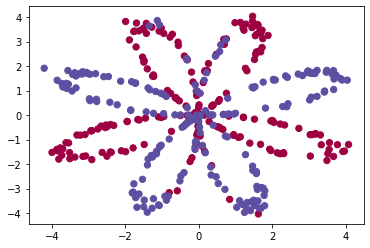

In [3]:
# Visualize the data:
# c: carray-like or list of colors or color, optional
# camp: str or Colormap, default: rcParams["image.cmap"] (default: 'viridis')
# A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
plt.show()

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('The dataset has m = %d examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
The dataset has m = 400 examples!


**Expected Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

**Cross validation**

Try to split the dataset into training and test set with the function train_test_split with test_size = 0.2 and random_state = 0.

Remenber to transpose the matrix before you input it into the function.

In [5]:
X = X.T
Y = Y.T
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0) 

## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
# ravel(): expand dimension
# https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
clf.fit(X_train, np.ravel(y_train));

You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: %d 51.24999999999999% (percentage of correctly labelled datapoints)


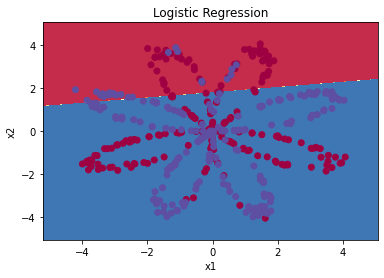

In [7]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T) # Dimensional purpose
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X_test)
accuracy_socre = clf.score(X_test, y_test)

# To print a number, we need to first convert it to a string by using 
print ('Accuracy of logistic regression: %d '+ str(accuracy_socre*100)+
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 51.24999999999999% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now!


**Extended reading**:
Proof that the decision boundary of logistics regression is linear:https://homes.cs.washington.edu/~marcotcr/blog/linear-classifiers/

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">


**Reminder**: The general methodology to build a Neural Network is to:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc) 
    2. Compile the model
    3. Fit the model
    4. Evaluate the model

Steps 3-4 are like what we did in Tuesday's lab section.

### 4.1 - 4.2  - Defining the neural network structure and compile the model ####

**Available metrics on Keras for regression and classification tasks:**
    
https://keras.io/api/metrics/

In [8]:
# Step 1: Define the neural network structure ( # of input units,  # of hidden units, etc).
def build_model(input_dim, #int
                first_hidden_layer_node_num = 4, #int
                activation_function='sigmoid' #str
               ):
    # define the keras model
    # https://keras.io/api/models/sequential/
    model = Sequential()
    # The model expects rows of data with 2 variables (the input_dim=2 argument)
    # The first hidden layer has 4 nodes and uses the tanh activation function
    model.add(Dense(first_hidden_layer_node_num, input_dim=input_dim, activation='tanh'))
    # The output layer has one node and uses the sigmoid activation function
    model.add(Dense(1, activation=activation_function))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'accuracy'])
    return model

**To help understand adam greadient decent method, an illustration is as below**


**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



### 4.3 - Fit the model ####
Now we fit the model with training data


In [9]:
# fit the keras model on the dataset
model = build_model(input_dim = 2, first_hidden_layer_node_num = 4, activation_function='sigmoid')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


### Reference of keras model.fit():
https://www.tensorflow.org/api_docs/python/tf/keras/Model

**batch_size**:

Integer or None. Number of samples per batch of computation. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of a dataset, generators, or keras.utils.Sequence instances (since they generate batches).

**verbose**:

0 or 1. Verbosity mode. 0 = silent, 1 = progress bar.

**epoch**:

Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.

### Reference of model history:

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

**Note**
F1 metrics have been removed from Keras core. You need to calculate them manually. They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful.

In [10]:
# train
# store the model into a file
mode_path = './simple_nn.h5'
callbacks = [ModelCheckpoint(filepath=mode_path)]
# fit the model
history = model.fit(X_train, y_train, epochs=150, batch_size=10, callbacks=callbacks)

Epoch 1/150
32/32 [==============================] - 9s 970us/step - loss: 0.6999 - auc: 0.5720 - accuracy: 0.5068
Epoch 2/150
32/32 [==============================] - 0s 989us/step - loss: 0.7187 - auc: 0.5387 - accuracy: 0.4665
Epoch 3/150
32/32 [==============================] - 0s 926us/step - loss: 0.7097 - auc: 0.5564 - accuracy: 0.4938
Epoch 4/150
32/32 [==============================] - 0s 944us/step - loss: 0.7047 - auc: 0.5629 - accuracy: 0.5372
Epoch 5/150
32/32 [==============================] - 0s 1ms/step - loss: 0.6833 - auc: 0.5894 - accuracy: 0.5587
Epoch 6/150
32/32 [==============================] - 0s 979us/step - loss: 0.6387 - auc: 0.6628 - accuracy: 0.6069
Epoch 7/150
32/32 [==============================] - 0s 1ms/step - loss: 0.6573 - auc: 0.6354 - accuracy: 0.5982
Epoch 8/150
32/32 [==============================] - 0s 984us/step - loss: 0.6335 - auc: 0.6659 - accuracy: 0.6141
Epoch 9/150
32/32 [==============================] - 0s 945us/step - loss: 0.6424 - 

Epoch 72/150
32/32 [==============================] - 0s 1ms/step - loss: 0.4150 - auc: 0.9166 - accuracy: 0.8458
Epoch 73/150
32/32 [==============================] - 0s 1ms/step - loss: 0.4262 - auc: 0.9065 - accuracy: 0.8432
Epoch 74/150
32/32 [==============================] - 0s 1ms/step - loss: 0.3841 - auc: 0.9466 - accuracy: 0.8782
Epoch 75/150
32/32 [==============================] - 0s 921us/step - loss: 0.4222 - auc: 0.9109 - accuracy: 0.8371
Epoch 76/150
32/32 [==============================] - 0s 911us/step - loss: 0.3963 - auc: 0.9362 - accuracy: 0.8604
Epoch 77/150
32/32 [==============================] - 0s 854us/step - loss: 0.4140 - auc: 0.9226 - accuracy: 0.8539
Epoch 78/150
32/32 [==============================] - 0s 904us/step - loss: 0.4287 - auc: 0.8995 - accuracy: 0.8188
Epoch 79/150
32/32 [==============================] - 0s 886us/step - loss: 0.4204 - auc: 0.9006 - accuracy: 0.8249
Epoch 80/150
32/32 [==============================] - 0s 849us/step - loss: 0.

32/32 [==============================] - 0s 1ms/step - loss: 0.3768 - auc: 0.9270 - accuracy: 0.8687
Epoch 143/150
32/32 [==============================] - 0s 1ms/step - loss: 0.3429 - auc: 0.9372 - accuracy: 0.8697
Epoch 144/150
32/32 [==============================] - 0s 953us/step - loss: 0.3438 - auc: 0.9366 - accuracy: 0.8660
Epoch 145/150
32/32 [==============================] - 0s 946us/step - loss: 0.3653 - auc: 0.9330 - accuracy: 0.8688
Epoch 146/150
32/32 [==============================] - 0s 1ms/step - loss: 0.3503 - auc: 0.9380 - accuracy: 0.8671
Epoch 147/150
32/32 [==============================] - 0s 924us/step - loss: 0.3597 - auc: 0.9302 - accuracy: 0.8717
Epoch 148/150
32/32 [==============================] - 0s 912us/step - loss: 0.3783 - auc: 0.9176 - accuracy: 0.8491
Epoch 149/150
32/32 [==============================] - 0s 1ms/step - loss: 0.3898 - auc: 0.9094 - accuracy: 0.8258
Epoch 150/150
32/32 [==============================] - 0s 865us/step - loss: 0.3616 - 

### 4.4 - Evaluate the model ####

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $1$ hidden units.

Details:

- %.2f stands for "print a float with 2 decimal places"
- %% prints a literal %

In [ ]:
# evaluate the nn model
_, auc_value, accuracy = model.evaluate(X_test, y_test)
print("%.2f%%" % (100 * auc_value))
print("%.2f%%" % (100 * accuracy))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**AUC on test set**</td>
    <td> around 90% percent </td> 
  </tr>
  <tr>
    <td>**Accuracy on test set**</td>
    <td> around 85% percent </td> 
  </tr>
  
</table>


In [ ]:
# Plot decision boundary
plot_decision_regions(X_test, y_test.reshape(-1), clf=model)
plt.show()

Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional/ungraded exercise) ###

Run the following code. It may take 1-5 minutes. You will observe different behaviors of the model for various hidden layer sizes.

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You might want to consider regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

In [ ]:
# Set plot size
plt.figure(figsize=(16, 32))
# https://www.geeksforgeeks.org/enumerate-in-python/
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 100]

auc_values = []
accuracy_values = []

for i, n_h in enumerate(hidden_layer_sizes):
    # Set plot location
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    model_i = build_model(input_dim = 2, first_hidden_layer_node_num = n_h, activation_function='sigmoid')
    # by setting verbose = 0,
    # we can let the model train silently without showing progress bar
    model_i.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    plot_decision_regions(X, Y.reshape(-1), clf=model_i)
    
    _, auc_value, accuracy = model_i.evaluate(X_test, y_test)
    auc_values.append(auc_value)
    accuracy_values.append(accuracy)
    print ("AUC: ", auc_value, "accuracy: ", accuracy, "Number of hidden layer: ", n_h)

3/3 [==============================] - 0s 1ms/step - loss: 0.6746 - auc: 0.5949 - accuracy: 0.6125
AUC:  0.5949488282203674 accuracy:  0.612500011920929 Number of hidden layer:  1


In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.title("auc, accuracy vs hidden layer size")
# Plot dash lines
plt.plot(hidden_layer_sizes, accuracy_values, label="Accuracy")
plt.plot(hidden_layer_sizes, auc_values, label="AUC")
plt.ylabel("Accuracy, AUC")
plt.xlabel("hidden layer size")
# Specify legend location and size
plt.legend(loc="lower left",fontsize = "large")
plt.ylim([0,1])
plt.show()

**Optional Section**

Some optional/ungraded questions that you can explore if you wish: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [ ]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Congrats on finishing this Programming Assignment!